# Real Time Implementation of AI: Face Mask Detector with MobileNetV2

In this report, I will show you step by step how to train a COVID-19 face mask detector using MobileNetV2 and OpenCV.

## Steps

In this report, we’ll discuss our three-phase COVID-19 face mask detector, detailing how our computer vision/deep learning will be implemented. I’ll then show you how to implement a Python script to train a face mask detector on our dataset using Keras and TensorFlow.
Given the trained COVID-19 face mask detector, we’ll proceed to implement tree more additional Python scripts used to:
1. Detect face masks in images
2. Detect face masks in real-time video streams
3. Implement our saved model into android mobile app.

We’ll wrap up the post by looking at the results of applying our face mask detector.

In order to train a custom face mask detector, we need to break our project into two distinct phases, each with its own respective sub-steps:
1. **Training:** Here we’ll focus on loading our dataset from disk, training a model on this dataset, and then serializing the face mask detector to disk
2. **Deployment:** Once the face mask detector is trained, we can then move on to loading the mask detector, performing face detection, and then classifying each face as *with_mask* or *without_mask*

In [56]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

To accomplish this task, we’ll be fine-tuning the **MobileNet V2 architecture**, a highly efficient architecture that can be applied to embedded devices with limited computational capacity (ex., Raspberry Pi, Google Coral, NVIDIA Jetson Nano, etc.). Deploying our face mask detector to embedded devices could reduce the cost of manufacturing such face mask detection systems, hence why we choose to use this architecture.

Our set of *tensorflow.keras* imports allow for:
- Data augmentation
- Loading the MobilNetV2 classifier (we will fine-tune this model with pre-trained ImageNet weights)
- Building a new fully-connected (FC) head
- Pre-processing
- Loading image data

We’ll use *scikit-learn* for binarizing class labels, segmenting our dataset, and printing a classification report.

My *imutils paths* implementation will help us to find and list images in our dataset. And we’ll use *matplotlib* to plot our training curves.

At this point, we’re ready to load and pre-process our training data:

In [57]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images("datasets"))
data = []
labels = []
# loop over the image paths
for imagePath in tqdm(imagePaths, desc = "importing images"):
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In this block, we are:

- Grabbing all of the **imagePaths** in the dataset
- Initializing **data** and **labels** lists
- Looping over the **imagePaths** and loading + pre-processing images. Pre-processing steps include resizing to **224×224 pixels**, conversion to array format, and scaling the pixel intensities in the input image to the range [-1, 1] (via the **preprocess_input** convenience function)
- Appending the pre-processed image and associated label to the data and labels lists, respectively
- Ensuring our training data is in NumPy array format (Lines 63 and 64)
The above lines of code assume that your entire dataset is small enough to fit into memory. If your dataset is larger than the memory you have available, I suggest using HDF5, a strategy I cover in Deep Learning for Computer Vision with Python (Practitioner Bundle Chapters 9 and 10).

Our data preparation work isn’t done yet. Next, we’ll encode our labels, partition our dataset, and prepare for data augmentation:

In [58]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

Using scikit-learn’s convenience method, segment our data into 80% training and the remaining 20% for testing.

During training, we’ll be applying on-the-fly mutations to our images in an effort to improve generalization. This is known as **data augmentation**, where the random rotation, zoom, shear, shift, and flip parameters are established on Lines 77-84. We’ll use the **aug** object at training time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

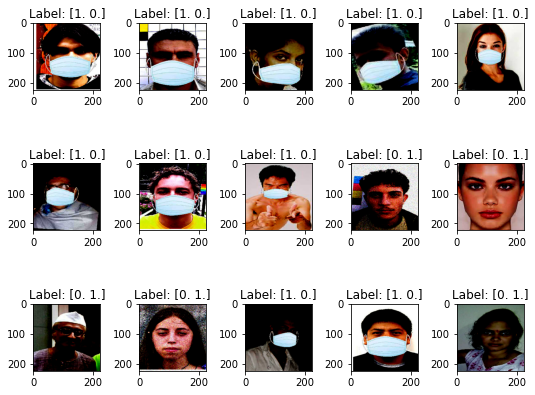

In [59]:
# plot first few images
num_row = 3
num_col = 5 # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(15):
	# define subplot
	ax = axes[i//num_col, i%num_col]
	# plot raw pixel data
	ax.imshow(trainX[i])
	ax.set_title("Label: {}".format(trainY[i]))
# show the figure
plt.tight_layout()
plt.show()

But first, we need to prepare MobileNetV2 for **fine-tuning**:

In [60]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
			input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

Fine-tuning setup is a three-step process:

1. Load MobileNet with pre-trained **ImageNet** weights, leaving off head of network
2. Construct a new FC head, and append it to the base in place of the old head
3. Freeze the base layers of the network. The weights of these base layers will not be updated during the process of backpropagation, whereas the head layer weights will be tuned.

With our data prepared and model architecture in place for fine-tuning, we’re now ready to compile and train our face mask detector network. Here, I’ve specified hyperparameter constants including my initial learning rate, number of training epochs, and batch size. We will be applying a learning rate decay schedule, which is why we’ve named the learning rate variable INIT_LR.

In [61]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [62]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, 
	metrics=["accuracy"])
	
# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 27s 587ms/step - loss: 0.5390 - accuracy: 0.7540 - val_loss: 0.2129 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 19s 540ms/step - loss: 0.2111 - accuracy: 0.9599 - val_loss: 0.1019 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 19s 551ms/step - loss: 0.1227 - accuracy: 0.9874 - val_loss: 0.0621 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 19s 555ms/step - loss: 0.0702 - accuracy: 0.9899 - val_loss: 0.0447 - val_accuracy: 1.0000
Epoch 5/20
34/34 [==============================] - 19s 566ms/step - loss: 0.0593 - accuracy: 0.9889 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 19s 550ms/step - loss: 0.0502 - accuracy: 0.9914 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 18s 537ms/step - loss: 0.0374 - accuracy: 0.9916 - val_loss: 0.0251 - val_accuracy: 0.9964

We **compile** our model with the Adam optimizer, a learning rate decay schedule, and **binary cross-entropy**. If you’re building from this training script with > 2 classes, be sure to use **categorical cross-entropy**.

Notice how our data **augmentation object (aug)** will be providing batches of mutated image data.

Once training is complete, we’ll evaluate the resulting model on the test set:

In [63]:
# make predictions on the testing set
print("evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("saving mask detector model [Done]")
model.save("models\mask_detector.h5")

evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

saving mask detector model [Done]


Here, we make predictions on the **test set**, grabbing the highest probability class label indices. Then, we print a classification report in the terminal for inspection. we also serializes our face mask classification model to disk.

Our last step is to plot our accuracy and loss curves:

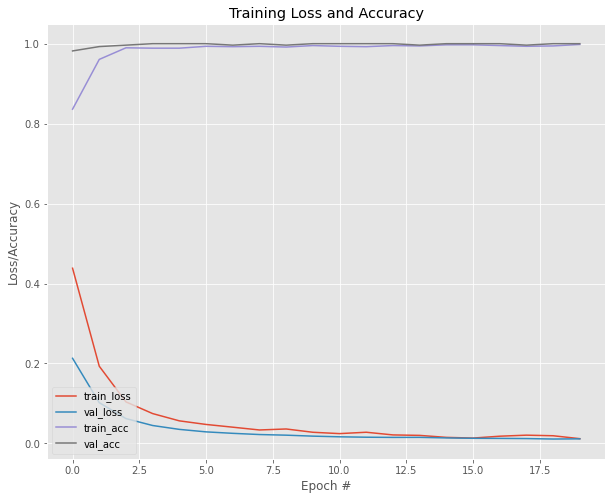

In [64]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

As you can see, we are obtaining **~99% accuracy** on our test set.

# Implementing our face mask detector in example images

Now that our face mask detector is trained, let’s learn how we can:

- Load an example image from disk "examples/example1.jpg"
- Detect faces in the image (using **CascadeClassifier()**)
- Apply our face mask detector to classify the face as either **with_mask** or **without_mask**

In [65]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

Our driver script requires three:
- TensorFlow/Keras imports to 
- load our MaskNet model, and
- pre-process the input image. 

OpenCV is required for display and image manipulations. Next, we’ll load both our face detector and face mask classifier models:


In [107]:
# call our serialized face detector model
print("loading face detector model [Done]")
cascPath = os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

# load the face mask detector model from disk
print("loading face mask detector model [Done]")
model = load_model("models/mask_detector.h5")

loading face detector model [Done]
loading face mask detector model [Done]


With our deep learning models now in memory, our next step is to load and pre-process an input image:

In [129]:
# load the input image from disk, clone it, and grab the image spatial dimensions
image = cv2.imread('examples/example2.jpg') # BGR format channels
image = cv2.resize(image, (800, 500))
# pass the image through the network and obtain the face detections
print("computing face detections [Done]")
faces = faceCascade.detectMultiScale(image, scaleFactor=1.2,
        minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

computing face detections [Done]


Once we know where each face is predicted to be, we’ll vizualize it:

In [130]:
# loop over the detections
for box in faces:
	# ensure the bounding boxes fall within the dimensions of
	# the frame
	startX, startY, width, height = box
	endX, endY = startX + width, startY + height
	# extract the face ROI, convert it from BGR to RGB channel
	# ordering, resize it to 224x224, and preprocess it
	face = image[startY:endY, startX:endX]
	face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
	face = cv2.resize(face, (224, 224))
	face = img_to_array(face)
	face = preprocess_input(face)
	face = np.expand_dims(face, axis=0)
	# pass the face through the model to determine if the face
	# has a mask or not
	(mask, withoutMask) = model.predict(face)[0]
	# determine the class label and color we'll use to draw
	# the bounding box and text
	label = "Mask" if mask > withoutMask else "No Mask"
	color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
	# include the probability in the label
	label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	# display the label and bounding box rectangle on the output
	# frame
	cv2.putText(image, label, (startX, startY - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
	cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
# keep the window open until we press a key
cv2.waitKey(0)

-1

Code above, we loop over our detections and extract box value for a particular face and ensure that the box falls within the boundaries of the image. In this block, we:

- Extract the face Region of Interest (ROI) via NumPy slicing
- Pre-process the ROI the same way we did during training
- Perform mask detection to predict **with_mask** or **without_mask**

First, we determine the class **label** based on probabilities returned by the mask detector model and assign an associated color for the annotation. The color will be **“green”** for **with_mask** and **“red”** for **without_mask**.

We then draw the label text (including class and probability), as well as a bounding box rectangle for the face, using OpenCV drawing functions. Once all detections have been processed, we display the output image.

# Implementing our face mask detector in real-time video streams

At this point, we know we can apply face mask detection to static images — **but what about real-time video streams?**

We try our face mask detector to be capable of running in real-time

In [119]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream, WebcamVideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

The algorithm for this script is the same, but it is pieced together in such a way to allow for processing every frame of your webcam stream.

Thus, the only difference when it comes to imports is that we need a **VideoStream** class and **time**. Both of these will help us to work with the stream. We’ll also take advantage of **imutils** for its aspect-aware resizing method.

In [120]:
def detect_and_predict_mask(image, faceNet, maskNet):
	# grab the dimensions of the frame and obtain the face detections
	frame = faceNet.detectMultiScale(image, scaleFactor=1.2,
        	minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []
    # loop over the detections
	for box in frame:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		startX, startY, width, height = box
		endX, endY = startX + width, startY + height
		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		# add the face and bounding boxes to their respective
		# lists
		faces.append(face)
		locs.append((startX, startY, endX, endY))
	
    # only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

Our **detect_and_predict_mask** function accepts three parameters:

- **image**: A frame/image from our stream
- **faceNet**: The model used to detect where in the image faces are
- **maskNet**: Our face mask classifier model

Secondly, we are performing inference on our entire batch of faces in the frame so that our pipeline is faster. It wouldn’t make sense to write another loop to make predictions on each face individually due to the overhead (especially if you are using a GPU that requires a lot of overhead communication on your system bus). **It is more efficient to perform predictions in batch.**

we just have a few initializations to handle before we loop over frames:

In [121]:
# call our serialized face detector model
print("loading face detector model [Done]")
cascPath = os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceNet = cv2.CascadeClassifier(cascPath)

# load the face mask detector model from disk
print("loading mask detector model [Done]")
maskNet = load_model("models/mask_detector.h5")

# initialize the video stream and allow the camera sensor to warm up
print("starting video stream [Done]")
vs = VideoStream(0).start()

loading face detector model [Done]
loading mask detector model [Done]
starting video stream [Done]


Let’s proceed to loop over frames in the stream:

In [122]:
# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=600)
	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred
		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

# Converting model from Keras to TensorFlow Lite

n this case we are going to use the **TocoConverter** python class to migrate from the Keras **‘.h5’** format to the TensorFlow Lite **‘.tflite’** format. It’s amazing how easy a high-level deep learning model can be ported to format suitable for mobile, simply by executing one line of code. The following python script does the job:

In [138]:
# Converts the Keras model to TensorFlow Lite
import tensorflow.lite as lite

# Convert the model
maskNet = load_model("models/mask_detector.h5")
converter = lite.TFLiteConverter.from_keras_model(maskNet)
tflite_model = converter.convert()

# Save the model
with open('models/mask_detector.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rauzan\AppData\Local\Temp\tmp0dh4cqhw\assets


INFO:tensorflow:Assets written to: C:\Users\rauzan\AppData\Local\Temp\tmp0dh4cqhw\assets


The model was conveniently created by using transfer learning over the MobileNetV2 architecture, producing a ‘.h5’ file of about 10.9 MB. After TensorFlow Lite conversion, the resulting file is very light-weight only 9.5 MB, really good for a mobile application.